In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import wasserstein_distance
from statsmodels.distributions.empirical_distribution import ECDF
import datetime
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions,histfit
import fitter
import math
import random
from numpy import exp
import pyreadstat
from sklearn import preprocessing
from matplotlib.lines import Line2D

from scipy.optimize import curve_fit

import json

#Avoiding Type 3 fonts in matplotlib plots
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'Arial'

In [2]:
font = {'size'   : 15}

matplotlib.rc('font', **font)
matplotlib.rc('lines', linewidth=2.0)
matplotlib.rc('lines', markersize=8)

In [3]:
res='results/'

## Dataset Reading

### MiD data 2017 Long distance
mobilität in deutschland

In [4]:
# data reading
'''
The data file can be asked from https://daten.clearingstelle-verkehr.de/order-form.html#223. 

wegkm: wegelänge, path length
hvm: hauptverkehrsmittel, main mode of transport
hvm_diff2: hauptverkehrsmittel (stärker differenziert), more differentiated

'''
df_MiD=pd.read_csv('../data/MiD2017_Wege.csv',decimal=',',sep=';',usecols=['wegkm','hvm','hvm_diff2','W_ZWECK','ST_JAHR','ST_MONAT'])
print(df_MiD.shape)
#exclude unwanted lines with "unknown" distance value et al
df_MiD=df_MiD[df_MiD.wegkm.isin([9994,9999,70703]) == False]
df_MiD.head(3)

(960619, 6)


,ST_MONAT,ST_JAHR,W_ZWECK,wegkm,hvm,hvm_diff2
0,3,2017,1,21.85,4,9
1,3,2017,5,0.39,1,1
2,3,2017,8,21.85,4,9


In [5]:
# Different transport modes extraction
df_MiD_public=df_MiD[df_MiD.hvm.isin([5]) == True] #public
# long range
df_MiD_LRpublic=df_MiD_public[df_MiD_public.hvm_diff2.isin([20,21,22,23])==True] 

## Fitting commonly used distributions to German long-distance data.

In [6]:
df_vec=df_MiD_LRpublic['wegkm'].copy() # Long distance in MiD 2017

In [7]:
'''
averages each bin with its neighboring bins
n_neighbors is the number of choosen neighbors(right side)
'''
def avg_neighbors(hist, n_neighbors=1):
    new_hist = np.zeros_like(hist)
    for i in range(len(hist)):
        start = max(0, i - n_neighbors)
        end = min(len(hist), i + n_neighbors + 1)
        new_hist[i] = np.mean(hist[start:end])
    return new_hist

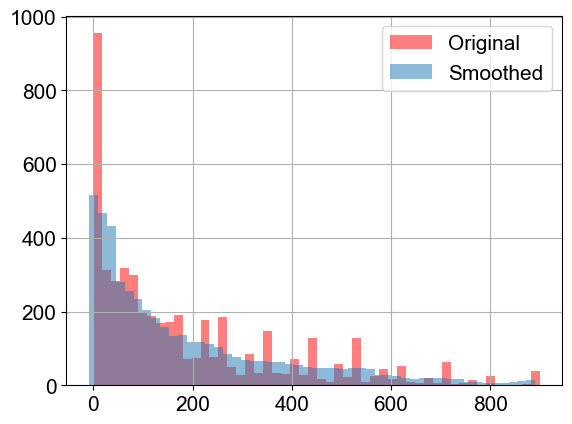

In [8]:
'''Smoothing data to reduce the noise from the original dataset

Due to some oscillations in the raw data, 
it's better to smooth it before finding the possible fitting distribution
'''
n_bins = 50 #number of bins
hist, bin_edges = np.histogram(df_vec, bins=n_bins) #bins here is bin edges or bin width

new_hist = avg_neighbors(hist, n_neighbors=2)
plt.hist(df_vec, bins=bin_edges, alpha=0.5, label='Original', color='red')
plt.bar(bin_edges[:-1], new_hist, width=np.diff(bin_edges), alpha=0.5, label='Smoothed')
plt.grid()
plt.legend()
plt.show()

In [9]:
'''
Generate artificial data according the smoothed histogram
Then find the possible distributions for fitting the artificial raw data.
'''
np.random.seed(666) #fixed

# Normalize the bin heights, which can be used as the probablity for choosing bin
total = sum(new_hist)
norm_heights = [h/total for h in new_hist]

# Calculate the bin widths and heights
bin_widths = bin_edges[1:] - bin_edges[:-1]

# Generate artificial data based on the histogram plot
n_samples = df_vec.shape[0]
arti_data = []
for i in range(n_samples):
    bin = np.random.choice(len(norm_heights), p=norm_heights)
    x = np.random.uniform(bin_edges[bin], bin_edges[bin+1])
    arti_data.append(x)

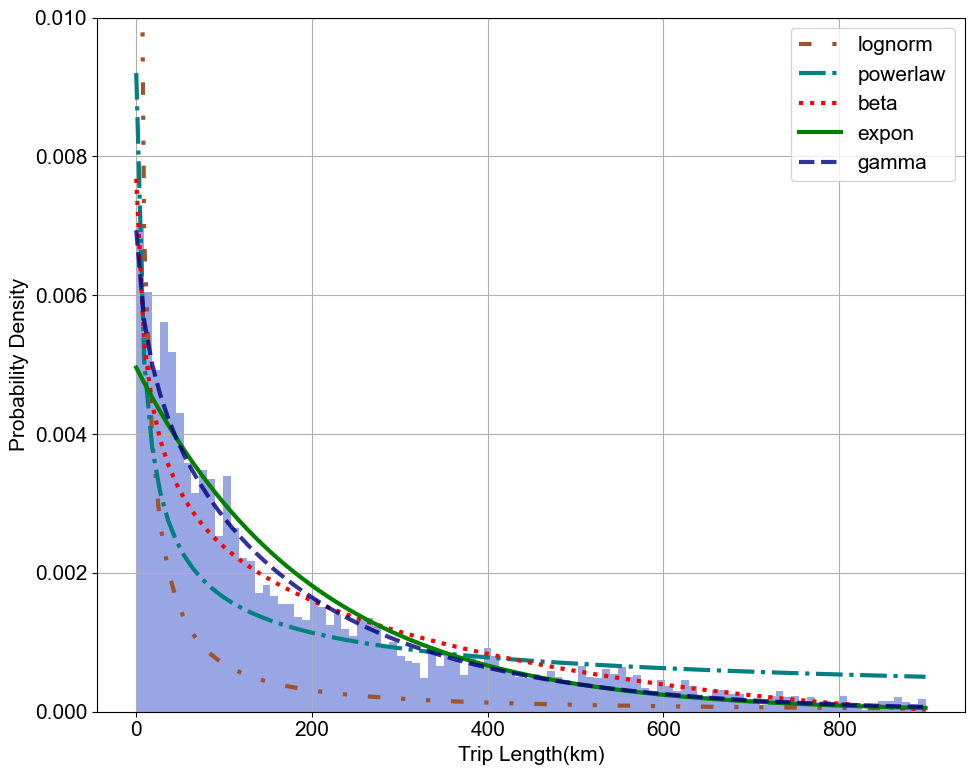

In [10]:

'''
Find and plot the possible distributions
'''

f = Fitter(arti_data,
           bins=100,
           # choose some kown bulit-in distributions to check the performance of these distributions
           distributions=[
                         'beta',
                         'expon',
                         'gamma',
                         'lognorm',
                         'powerlaw'
           ])

f.fit()
fig, ax = plt.subplots(figsize=(10,8))

data_bins = np.linspace(min(arti_data), max(arti_data), 100)
plt.plot(data_bins, f.fitted_pdf['lognorm'], label='lognorm',color='sienna',linestyle=(0,(3,5,1,5,1,5)),lw=3)
plt.plot(data_bins, f.fitted_pdf['powerlaw'], label='powerlaw',color='teal', linestyle='dashdot',lw=3)
plt.plot(data_bins, f.fitted_pdf['beta'], label='beta',color='red', linestyle='dotted',lw=3)
plt.plot(data_bins, f.fitted_pdf['expon'], label='expon',color='green',linestyle='solid',lw=3)

plt.plot(data_bins, f.fitted_pdf['gamma'], label='gamma',color='navy',alpha=0.8,linestyle='dashed',lw=3)

plt.hist(arti_data, bins=100,alpha=0.8, color='#7F90DD',density=True)
plt.legend()
plt.grid()

plt.ylabel('Probability Density')
plt.xlabel('Trip Length(km)')
plt.ylim(0,0.01)

plt.tight_layout()
plt.savefig(res+'Possible Distributions.png', dpi=100, bbox_inches='tight')